## Prepare corpus

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [47]:
from ner_utils import *

In [8]:
initialize_random_seeds()

In [9]:
corpus_path = r'tagged_corpus.txt'

In [10]:
conll = pd.read_csv('joint_with_orig_form.conll')

In [11]:
sents = []

def add_to_sents(g):
    sents.append(list(zip(g.sort_values('ID').WORD.tolist(),g.sort_values('ID').orig_form.tolist())))
    return 0
conll.groupby('sent').apply(add_to_sents)

sent
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
       ..
3453    0
3454    0
3455    0
3456    0
3457    0
3458    0
3459    0
3460    0
3461    0
3462    0
3463    0
3464    0
3465    0
3466    0
3467    0
3468    0
3469    0
3470    0
3471    0
3472    0
3473    0
3474    0
3475    0
3476    0
3477    0
3478    0
3479    0
3480    0
3481    0
3482    0
Length: 3482, dtype: int64

In [12]:
start_idx = 0
new_numbering = []
for sent in sents[1:]:
    for w, form in sent:
        new_numbering.append(w+start_idx)
    start_idx = w+start_idx
    
new_numbering[-5:]

[63068, 63069, 63069, 63070, 63071]

In [13]:
conll['word_global'] = new_numbering
conll.word_global.head(20)

0      1
1      2
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
16    16
17    17
18    17
19    17
Name: word_global, dtype: int64

In [14]:
tg = pd.read_csv(corpus_path, sep=' ', skiprows=1, names=['corpus_form', 'NER'], quoting=3).reset_index()
tg['index'] = tg['index']+1
tg.head(50)

,index,corpus_form,NER
0,1,נראה,O
1,2,שאביטל,I_PERS
2,3,אברג'יל,I_PERS
3,4,(,O
4,5,לשעבר,O
5,6,אוז,I_PERS
6,7,),O
7,8,",",O
8,9,אוהבת,O
9,10,לא,O


In [15]:
conll = conll.merge(tg, how='left', left_on='word_global', right_on='index')

In [16]:
conll.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,...,head_form,head_upos,WORD,lat_idx_start,lat_idx_end,orig_form,word_global,index,corpus_form,NER
0,1,נראה,NaN,VB,VB,NaN,0,ROOT,_,_,...,NaN,NaN,1,0,1,נראה,1,1,נראה,O
1,2,ש,NaN,REL,REL,NaN,1,dep,_,_,...,נראה,VB,2,1,2,שאביטל,2,2,שאביטל,I_PERS
2,3,אביטל,NaN,NNP,NNP,NaN,0,ROOT,_,_,...,NaN,NaN,2,2,3,שאביטל,2,2,שאביטל,I_PERS
3,4,אברג'יל,NaN,NNP,NNP,NaN,3,complmn,_,_,...,אביטל,NNP,3,3,4,אברג'יל,3,3,אברג'יל,I_PERS
4,5,(,NaN,yyLRB,yyLRB,NaN,4,pcomp,_,_,...,אברג'יל,NNP,4,4,5,(,4,4,(,O


In [17]:
a = [1,2,3,4]
[2] + [1]*4

[2, 1, 1, 1, 1]

In [18]:
new_tags = []
def fix_bio(g):
    sz = g.shape[0]
    frst = g.NER.iat[0]
    if frst.startswith('B_'):
        tgs = [g.NER.iat[0]] + ['I_'+frst[2:]]*(sz-1)
    else:
        tgs = [frst]*sz
    new_tags.extend(tgs)

conll.groupby('word_global').apply(fix_bio)
            

""


In [19]:
conll['NER_fixed'] = new_tags[1:]

In [20]:
conll.head().T

,0,1,2,3,4
ID,1,2,3,4,5
FORM,נראה,ש,אביטל,אברג'יל,(
LEMMA,NaN,NaN,NaN,NaN,NaN
UPOS,VB,REL,NNP,NNP,yyLRB
XPOS,VB,REL,NNP,NNP,yyLRB
FEATS,NaN,NaN,NaN,NaN,NaN
HEAD,0,1,0,3,4
DEPREL,ROOT,dep,ROOT,complmn,pcomp
DEPS,_,_,_,_,_
MISC,_,_,_,_,_


In [21]:
x = conll

In [22]:
sents = x.groupby('sent')[['FORM', 'UPOS', 'NER_fixed']].apply(lambda x: x.values.tolist())
sents[:5]

sent
1    [[נראה, VB, O], [ש, REL, I_PERS], [אביטל, NNP,...
2    [[תורג'מן, NNP, I_PERS], [,, yyCM, O], [ש, REL...
3    [[הפגישה, VB, O], [ה, DEF, O], [מרגשת, JJ, O],...
4    [[ב, PREPOSITION, O], [ה, DEF, O], [שלב, NN, O...
5    [[אברג'יל, NNP, I_PERS], [,, yyCM, O], [נבוכה,...
dtype: object

In [23]:
words = list(set(x["FORM"].values))
n_words = len(words); n_words

12936

In [24]:
tags = list(set(x["NER_fixed"].values))
n_tags = len(tags); n_tags

18

In [25]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [26]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sents]

In [27]:
X = pad_sequences(maxlen=max_len, sequences=X, value=word2idx["PAD"], padding='post', truncating='post')

In [28]:
X[1]

array([12776,  7668, 10385,  9868, 11745,  9409,  5940,  9204,  4884,
       10708,  7239, 10511,  9755,  9661,  7668,  3891, 12027,  7252,
        8969,  9411,  7252, 10091,  4284, 12207,  3556, 11406,  6076,
       11406, 12027,  9580,  7668, 10979,  9749,  4284,  7301,  4695,
        3319, 11578, 11927,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [29]:
pos = list(set(x["UPOS"].values))
n_pos = len(pos); n_pos

46

In [30]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0
X_pos = [[pos2idx[w[1]] for w in s] for s in sents]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos[0]

array([18,  3, 44, 44, 40, 15, 44, 19, 43, 30, 15, 15, 18, 10, 44, 44, 40,
       11, 34, 42, 22, 42,  4, 22, 19, 43, 31, 15, 10,  9,  6,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

## True tags

In [31]:
y = [[tag2idx[w[2]] for w in s] for s in sents]
y_numer = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [32]:
y_numer[1]

array([ 3,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  3,  3,  6,  6, 14,
       14, 14, 14,  6,  6,  6,  6,  6,  6, 16,  6, 17, 17,  6,  6,  6,  6,
        6,  3,  6,  6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [33]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y_numer]
y[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Perform train test splits

In [34]:
from sklearn.model_selection import train_test_split

splits = [train_test_split(X, y, X_pos, test_size=0.25, random_state=42+i) for i in range(3)]

### Prep char input

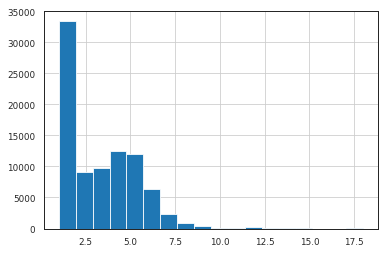

In [35]:
x.FORM.apply(len).hist(bins=18)

In [36]:
max_len_char = 10

In [37]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

101


In [38]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [39]:
X_char = []
for sentence in sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [40]:
splits_char = [train_test_split(X_char, y, test_size=0.25, random_state=42+i) for i in range(3)]

## Embeddings

In [41]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec'}

In [42]:
exclude = ['cbow']

In [43]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 776
sample words not found:  ['באקוולד' 'הדגשתי' 'מטוסינו' '2.50%-' 'עלCNN' 'ידרדרים' 'יתוניה'
 'אותוריטה' 'קנזאס' 'אבידוב']
loading word embeddings: ../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 776
sample words not found:  ['מסעדונות' 'ימצאיה' 'נויהארט' 'סטאר-נייט' 'דאלדה' 'פילנטרופואידים'
 'ארקיה' '1988.' 'פלגיאטיזם' '0991']
loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 776
sample words not found:  ['העטה' 'קפיטל-ברגר' 'נעצבנו' '2006,' 'קולקטיווי' '100.7' 'התגמד' '%20'
 'מכופלת' 'מסצוסטס']
loading word embeddings: ../wordembedding-hebrew/wikipedia.tokenized.word2vec_ski

## Model building

In [48]:
configs = build_configs(base_configs, embedding_mats)
configs     

[{'crf': True, 'use_pos': False},
 {'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_

In [49]:
out_folder = 'outputs3'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

Train on 2349 samples, validate on 262 samples
Epoch 1/100
 - 28s - loss: 0.4625 - crf_accuracy: 0.8983 - val_loss: 0.2474 - val_crf_accuracy: 0.9489
Epoch 2/100
 - 22s - loss: 0.2045 - crf_accuracy: 0.9556 - val_loss: 0.2021 - val_crf_accuracy: 0.9508
Epoch 3/100
 - 24s - loss: 0.1642 - crf_accuracy: 0.9571 - val_loss: 0.1693 - val_crf_accuracy: 0.9546
Epoch 4/100
 - 22s - loss: 0.1345 - crf_accuracy: 0.9614 - val_loss: 0.1537 - val_crf_accuracy: 0.9584
Epoch 5/100
 - 23s - loss: 0.1100 - crf_accuracy: 0.9667 - val_loss: 0.1329 - val_crf_accuracy: 0.9630
Epoch 6/100
 - 24s - loss: 0.0880 - crf_accuracy: 0.9730 - val_loss: 0.1227 - val_crf_accuracy: 0.9639
Epoch 7/100
 - 24s - loss: 0.0692 - crf_accuracy: 0.9786 - val_loss: 0.1078 - val_crf_accuracy: 0.9691
Epoch 8/100
 - 24s - loss: 0.0548 - crf_accuracy: 0.9831 - val_loss: 0.1079 - val_crf_accuracy: 0.9695
Epoch 9/100
 - 24s - loss: 0.0422 - crf_accuracy: 0.9866 - val_loss: 0.1063 - val_crf_accuracy: 0.9654
Epoch 10/100
 - 24s - loss

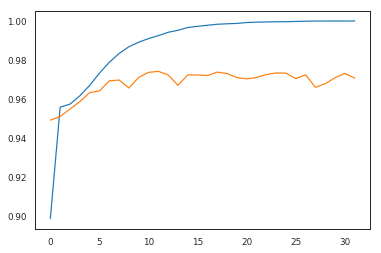

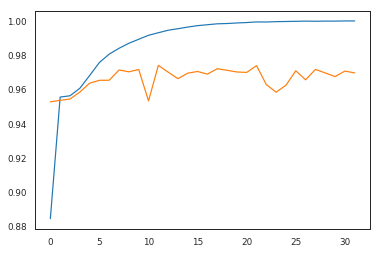

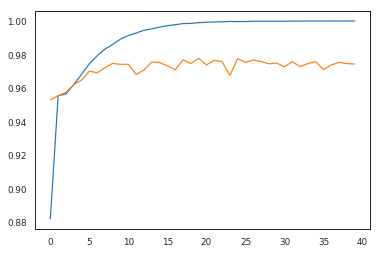

processed 21544 tokens with 1278 phrases; found: 1013 phrases; correct: 557.
accuracy:  53.57%; (non-O)
accuracy:  93.11%; precision:  54.99%; recall:  43.58%; FB1:  48.63
             DATE: precision:  41.54%; recall:  26.47%; FB1:  32.34  65
              LOC: precision:  51.42%; recall:  43.34%; FB1:  47.04  247
        MISC--AFF: precision:  64.74%; recall:  67.07%; FB1:  65.88  173
        MISC--ENT: precision:   8.33%; recall:   7.14%; FB1:   7.69  12
       MISC-EVENT: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
            MONEY: precision:  63.04%; recall:  61.70%; FB1:  62.37  46
              ORG: precision:  44.61%; recall:  35.83%; FB1:  39.74  204
          PERCENT: precision:  43.75%; recall:  12.96%; FB1:  20.00  16
             PERS: precision:  65.99%; recall:  49.85%; FB1:  56.79  247
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
processed 20959 tokens with 1281 phrases; found: 1055 phrases; correct: 583.
accuracy:  54.07%; (non-O)
ac

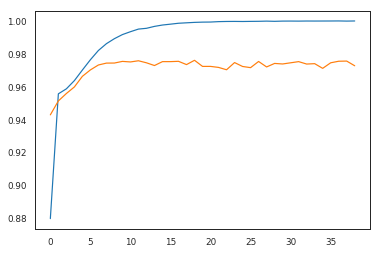

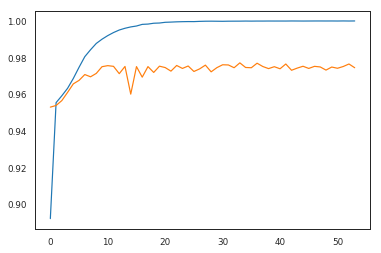

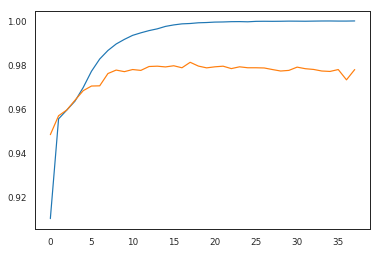

processed 21544 tokens with 1278 phrases; found: 1148 phrases; correct: 731.
accuracy:  65.26%; (non-O)
accuracy:  94.18%; precision:  63.68%; recall:  57.20%; FB1:  60.26
             DATE: precision:  67.47%; recall:  54.90%; FB1:  60.54  83
              LOC: precision:  62.61%; recall:  50.85%; FB1:  56.12  238
        MISC--AFF: precision:  79.01%; recall:  76.65%; FB1:  77.81  162
        MISC--ENT: precision:  12.50%; recall:  21.43%; FB1:  15.79  24
       MISC-EVENT: precision:   5.26%; recall:  11.11%; FB1:   7.14  19
            MONEY: precision:  80.00%; recall:  76.60%; FB1:  78.26  45
              ORG: precision:  50.22%; recall:  44.49%; FB1:  47.18  225
          PERCENT: precision:  86.36%; recall:  70.37%; FB1:  77.55  44
             PERS: precision:  68.32%; recall:  63.30%; FB1:  65.71  303
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
processed 20959 tokens with 1281 phrases; found: 1340 phrases; correct: 802.
accuracy:  69.65%; (non-O)
a

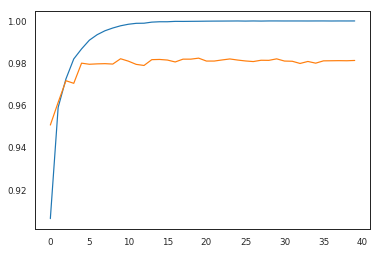

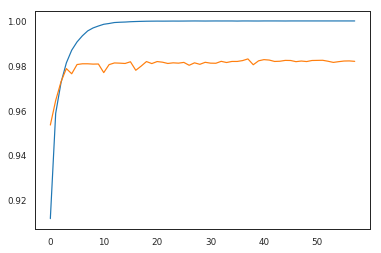

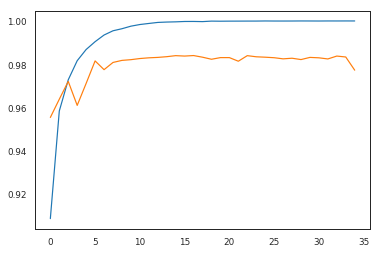

processed 21544 tokens with 1278 phrases; found: 1278 phrases; correct: 903.
accuracy:  78.66%; (non-O)
accuracy:  95.68%; precision:  70.66%; recall:  70.66%; FB1:  70.66
             DATE: precision:  74.74%; recall:  69.61%; FB1:  72.08  95
              LOC: precision:  68.04%; recall:  73.38%; FB1:  70.61  316
        MISC--AFF: precision:  86.79%; recall:  82.63%; FB1:  84.66  159
        MISC--ENT: precision:  31.82%; recall:  50.00%; FB1:  38.89  22
       MISC-EVENT: precision:  54.55%; recall:  66.67%; FB1:  60.00  11
            MONEY: precision:  78.85%; recall:  87.23%; FB1:  82.83  52
              ORG: precision:  59.77%; recall:  61.42%; FB1:  60.58  261
          PERCENT: precision:  75.00%; recall:  50.00%; FB1:  60.00  36
             PERS: precision:  74.69%; recall:  73.09%; FB1:  73.88  320
             TIME: precision:  50.00%; recall:  27.27%; FB1:  35.29  6
processed 20959 tokens with 1281 phrases; found: 1381 phrases; correct: 883.
accuracy:  77.18%; (non-O)
a

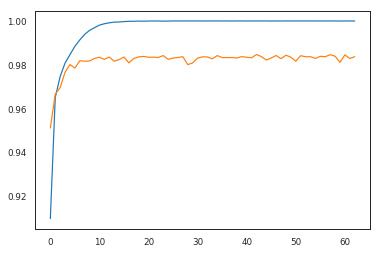

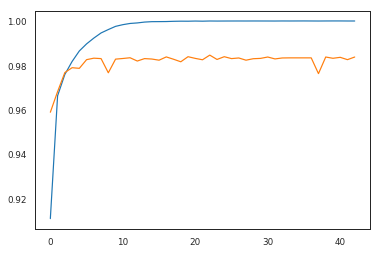

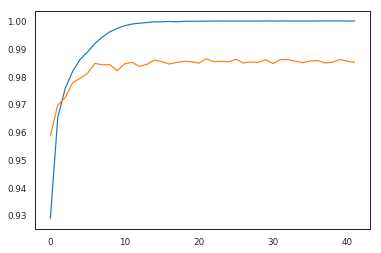

processed 21544 tokens with 1278 phrases; found: 1369 phrases; correct: 927.
accuracy:  80.09%; (non-O)
accuracy:  95.69%; precision:  67.71%; recall:  72.54%; FB1:  70.04
             DATE: precision:  61.79%; recall:  74.51%; FB1:  67.56  123
              LOC: precision:  72.55%; recall:  75.77%; FB1:  74.12  306
        MISC--AFF: precision:  82.76%; recall:  86.23%; FB1:  84.46  174
        MISC--ENT: precision:  18.18%; recall:  28.57%; FB1:  22.22  22
       MISC-EVENT: precision:  33.33%; recall:  55.56%; FB1:  41.67  15
            MONEY: precision:  76.92%; recall:  85.11%; FB1:  80.81  52
              ORG: precision:  54.32%; recall:  59.45%; FB1:  56.77  278
          PERCENT: precision:  77.36%; recall:  75.93%; FB1:  76.64  53
             PERS: precision:  71.01%; recall:  73.39%; FB1:  72.18  338
             TIME: precision:  50.00%; recall:  36.36%; FB1:  42.11  8
processed 20959 tokens with 1281 phrases; found: 1308 phrases; correct: 914.
accuracy:  78.04%; (non-O)


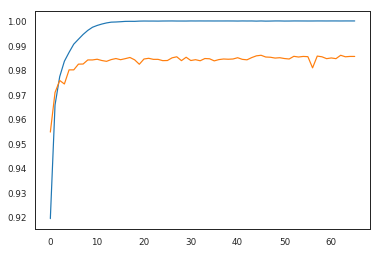

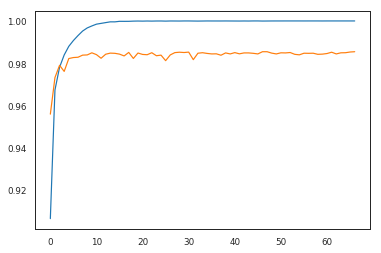

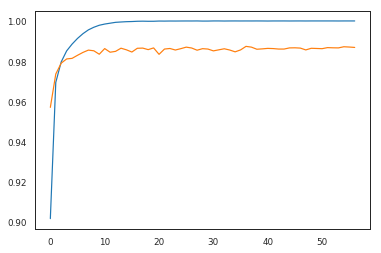

processed 21544 tokens with 1278 phrases; found: 1346 phrases; correct: 947.
accuracy:  80.34%; (non-O)
accuracy:  96.06%; precision:  70.36%; recall:  74.10%; FB1:  72.18
             DATE: precision:  70.54%; recall:  77.45%; FB1:  73.83  112
              LOC: precision:  73.57%; recall:  78.84%; FB1:  76.11  314
        MISC--AFF: precision:  81.67%; recall:  88.02%; FB1:  84.73  180
        MISC--ENT: precision:  35.71%; recall:  35.71%; FB1:  35.71  14
       MISC-EVENT: precision:  15.00%; recall:  33.33%; FB1:  20.69  20
            MONEY: precision:  82.00%; recall:  87.23%; FB1:  84.54  50
              ORG: precision:  58.04%; recall:  58.27%; FB1:  58.15  255
          PERCENT: precision:  84.09%; recall:  68.52%; FB1:  75.51  44
             PERS: precision:  72.57%; recall:  77.68%; FB1:  75.04  350
             TIME: precision:  28.57%; recall:  18.18%; FB1:  22.22  7
processed 20959 tokens with 1281 phrases; found: 1321 phrases; correct: 936.
accuracy:  79.12%; (non-O)


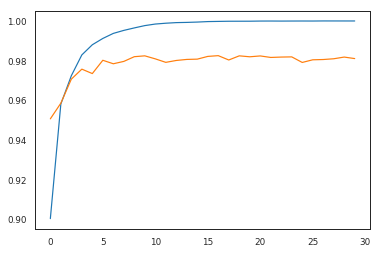

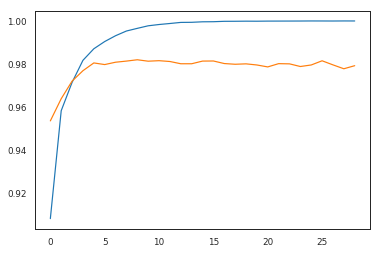

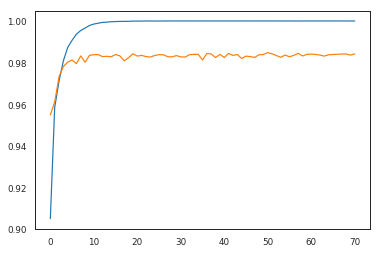

processed 21544 tokens with 1278 phrases; found: 1185 phrases; correct: 834.
accuracy:  73.52%; (non-O)
accuracy:  95.41%; precision:  70.38%; recall:  65.26%; FB1:  67.72
             DATE: precision:  69.66%; recall:  60.78%; FB1:  64.92  89
              LOC: precision:  70.07%; recall:  65.53%; FB1:  67.72  274
        MISC--AFF: precision:  87.82%; recall:  82.04%; FB1:  84.83  156
        MISC--ENT: precision:  38.89%; recall:  50.00%; FB1:  43.75  18
       MISC-EVENT: precision:  27.78%; recall:  55.56%; FB1:  37.04  18
            MONEY: precision:  83.33%; recall:  85.11%; FB1:  84.21  48
              ORG: precision:  54.27%; recall:  50.00%; FB1:  52.05  234
          PERCENT: precision:  75.00%; recall:  55.56%; FB1:  63.83  40
             PERS: precision:  76.72%; recall:  71.56%; FB1:  74.05  305
             TIME: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
processed 20959 tokens with 1281 phrases; found: 1251 phrases; correct: 838.
accuracy:  75.63%; (non-O)
a

In [ ]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='naama_morph', out_folder=out_folder,
                                                skip_if_model_exists=True)

In [51]:
results

[[(54.98519249753209, 43.58372456964006, 48.625054561326934),
  (55.26066350710901, 45.51131928181108, 49.91438356164384),
  (53.10110450297366, 48.15100154083205, 50.5050505050505)],
 [(63.67595818815332, 57.19874804381847, 60.26380873866447),
  (59.85074626865672, 62.60733801717409, 61.198016024418166),
  (64.29177268871925, 58.39753466872111, 61.20306822769479)],
 [(70.65727699530517, 70.65727699530517, 70.65727699530517),
  (63.939174511223754, 68.93052302888368, 66.34109691960931),
  (68.19317235636969, 63.09707241910631, 65.54621848739495)],
 [(67.7136596055515, 72.53521126760563, 70.04155647903288),
  (69.8776758409786, 71.35050741608119, 70.60641174198533),
  (68.37349397590361, 69.9537750385208, 69.15460776846915)],
 [(70.35661218424963, 74.1001564945227, 72.1798780487805),
  (70.8554125662377, 73.06791569086651, 71.9446579554189),
  (68.81005173688101, 71.72573189522342, 70.23764617125613)],
 [(70.37974683544303, 65.25821596244131, 67.72228989037757),
  (66.98641087130297, 65

In [46]:
for c in configs:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 

In [47]:
defaults = {'use_word': True, 'use_pos': False, 'embedding_matrix': None, 
            'embed_dim': 70, 'trainable': True, 'input_dropout': False, 
            'stack_lstm': 1, 'epochs': 100, 'early_stopping': True, 'patience': 20, 
            'min_delta': 0.0001, 'use_char': False, 'crf': False, 'stack_cross': False, 
            'stack_double': False, 'rec_dropout': 0.1}

In [48]:
for conf in configs:
    conf.update({'use_morpheme': True})
    conf.update({'use_word': False})

    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]

In [ ]:
len(list(zip(configs, results, preds, histories)))

In [52]:
def get_results_df(configs, results):
    dict_res = []
    for conf, res in zip(configs, results):
        dr = {}
        for i, r in enumerate(res):
            split_name = chr(ord('a')+i)
            dr['prec_'+split_name], dr['recall_'+split_name], dr['f1_'+split_name] = r
        dr.update(conf)
        dict_res.append(dr)
    rdf = (pd.DataFrame(dict_res)
           .assign(prec = lambda x: (x.prec_a + x.prec_b + x.prec_c)/3)
           .assign(recall = lambda x: (x.recall_a + x.recall_b + x.recall_c)/3)
           .assign(f1 = lambda x: (x.f1_a + x.f1_b + x.f1_c)/3))
    return rdf

In [53]:
res1 = pickle.load(open('treebank_results_1.pkl', 'rb'))

In [54]:
res2 = pickle.load(open('treebank_results_2_test25.pkl', 'rb'))

In [57]:
rdf1 = get_results_df([c for c, r, h in res1], [r for c, r, h in res1])

In [58]:
rdf2 = get_results_df([c for c, r, p, h in res2], [r for c, r, p, h in res2])

In [60]:
rdf2.head()

,crf,early_stopping,embed_dim,embedding_matrix,epochs,f1_a,f1_b,f1_c,input_dropout,min_delta,...,stack_double,stack_lstm,trainable,use_char,use_morpheme,use_pos,use_word,prec,recall,f1
0,True,True,70,None,100,61.595231,64.524986,63.937419,False,0.0001,...,False,1,True,False,True,False,False,66.866298,60.221498,63.352545
1,True,True,70,None,100,72.074967,71.615721,72.101911,False,0.0001,...,False,1,True,False,True,True,False,73.574440,70.383441,71.930866
2,True,True,300,fastext,100,77.924131,76.407437,77.421053,False,0.0001,...,False,1,True,False,True,False,False,78.371539,76.234033,77.250873
3,True,True,300,fastext,100,80.941052,79.862215,80.050761,False,0.0001,...,False,1,True,False,True,True,False,80.810288,79.768234,80.284676
4,True,True,70,None,100,69.732492,67.697498,70.299037,False,0.0001,...,False,1,True,True,True,False,False,74.882658,64.751970,69.243009


In [61]:
 (rdf2.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                63.4  71.9  69.2  75.0
fastext           77.3  80.3  82.0  83.3

In [63]:
 (rdf1.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                67.9  74.4  70.7  75.8
fastext           79.4  83.4  82.9  84.6